# 🚕 Taksi Ortamı ile Q-Öğrenme Eğitimi

Bu proje, özel bir 10x10 taksi haritasında **Q-learning** algoritması kullanarak bir taksinin yolcu alıp hedefe güvenli şekilde götürmeyi öğrenmesini amaçlar.

---

## 🗺️ Harita ve Engeller
- Harita görselden (`taksi.png`) alınır.
- Kırmızı hücreler 🚫 (geçilemez alanlar)
- Kahverengi tuğla duvarlar 🧱 (geçilemez duvarlar)
- Bu hücreler otomatik olarak tespit edilerek eğitim ortamı hazırlanır.

---

## 🧩 Ortamın Yapısı (`CustomTaxiEnv`)
- **Izgara:** 10x10 hücre (her biri 50x50 px)
- **Özellikler:**
  - Taksi: 🟡 özel ikonla
  - Yolcu: 🧍 özel ikonla
  - Hedef: 🟩 yeşil kare
  - Geçilemez alanlar: 🔴 kırmızı/kahverengi
- **Durum (state):**
  `(taksi_x, taksi_y, yolcu_x, yolcu_y, yolcu_taksidemi)`

---

## 🎮 Aksiyonlar
| Aksiyon Kodu | Açıklama              |
|--------------|-----------------------|
| 0            | Yukarı git            |
| 1            | Aşağı git             |
| 2            | Sola git              |
| 3            | Sağa git              |
| 4            | Yolcuyu al (pick up)  |
| 5            | Yolcuyu bırak (drop)  |

---

## 🏆 Ödül Sistemi
| Olay                          | Ödül   |
|-------------------------------|--------|
| Yolcuyu doğru yerde alma      | +10    |
| Yolcuyu doğru yerde bırakma   | +20    |
| Yanlış pick/drop              | -10    |
| Her adım                      | -1     |

---

## 👁️ Görselleştirme (Render)
- **Yolcu taksideyse:**  
  🔴 Taksinin etrafına **kırmızı çember** çizilir  
  ❌ Yolcunun alındığı yere **kırmızı "X"** çizilir

- **Yolcu dışarıdaysa:**  
  Yolcu ikonu gösterilir

- **Hedef:**  
  🟩 Yeşil kutu olarak görünür

- **Taksi:**  
  Taksi ikonu her zaman görünür

---

## 🤖 Q-learning Eğitimi
- Toplam **5000 bölüm**
- Aksiyonlar rastgele keşfedilir veya Q-table’dan seçilir
- Her adımda Q-table güncellenir:
  ```python
  Q(s, a) ← (1 - α) * Q(s, a) + α * [r + γ * max Q(s', a')]



In [1]:
# Gerekli kütüphaneleri yükle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import gym
from gym import spaces
import random
import os
import pickle
from IPython.display import clear_output, display
import time

In [2]:
from google.colab import drive
drive.mount("/content/drive")
#colab bağlantısı yapıldı

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Görselden kırmızı hücreleri (geçilemez alanları) ve kahverengi tuğla duvarları tespit eden fonksiyon
def load_invalid_cells(image_path, grid_size=10):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((500, 500))  # Harita 500x500 px, her kare 50x50 px
    cell_size = img.width // grid_size
    invalid_cells = set()

    for i in range(grid_size):
        for j in range(grid_size):
            x0, y0 = j * cell_size, i * cell_size
            x1, y1 = x0 + cell_size, y0 + cell_size
            cell = img.crop((x0, y0, x1, y1))
            avg_color = np.array(cell).mean(axis=(0, 1))
            r, g, b = avg_color
            # Renk kırmızıya yakınsa geçilmez olarak işaretle
            if r > 180 and g < 80 and b < 80:
                invalid_cells.add((j, i))  # x, y
            # Renk kahverengiye yakınsa tuğla duvar olarak işaretle
            if 170 < r < 200 and 140 < g < 170 and 100 < b < 130:
                invalid_cells.add((j, i))  # x, y

    return invalid_cells, img

In [4]:
# Haritayı ve geçilmez hücreleri yükle
invalid_cells, taksi_map = load_invalid_cells("/content/drive/MyDrive/taksi/taksi.png")

In [5]:
# Özel Taksi Ortamı
class CustomTaxiEnv(gym.Env):
    def __init__(self, grid_size=10, invalid_cells=None):
        super(CustomTaxiEnv, self).__init__()
        self.grid_size = grid_size
        self.invalid_cells = invalid_cells or set()
        self.action_space = spaces.Discrete(6)  # up, down, left, right, pick, drop
        self.observation_space = spaces.MultiDiscrete([grid_size, grid_size, grid_size, grid_size, 2])

        # İkonları yükle
        self.passenger_icon = Image.open("/content/drive/MyDrive/taksi/yolcu.png").convert("RGBA")
        self.taxi_icon = Image.open("/content/drive/MyDrive/taksi/taksi_icon.png").convert("RGBA")

        self.reset()

    def reset(self):
        while True:
            self.taxi_x = random.randint(0, self.grid_size - 1)
            self.taxi_y = random.randint(0, self.grid_size - 1)
            if (self.taxi_x, self.taxi_y) not in self.invalid_cells:
                break

        while True:
            self.passenger_x = random.randint(0, self.grid_size - 1)
            self.passenger_y = random.randint(0, self.grid_size - 1)
            if (self.passenger_x, self.passenger_y) not in self.invalid_cells:
                break

        while True:
            self.destination_x = random.randint(0, self.grid_size - 1)
            self.destination_y = random.randint(0, self.grid_size - 1)
            if (self.destination_x, self.destination_y) not in self.invalid_cells:
                break

        self.passenger_in_taxi = 0
        self.passenger_original_pos = (self.passenger_x, self.passenger_y)
        return self._get_state()

    def _get_state(self):
        return (self.taxi_x, self.taxi_y, self.passenger_x, self.passenger_y, self.passenger_in_taxi)

    def step(self, action):
        reward = -1
        done = False

        if action == 0 and self.taxi_y > 0 and (self.taxi_x, self.taxi_y - 1) not in self.invalid_cells:
            self.taxi_y -= 1
        elif action == 1 and self.taxi_y < self.grid_size - 1 and (self.taxi_x, self.taxi_y + 1) not in self.invalid_cells:
            self.taxi_y += 1
        elif action == 2 and self.taxi_x > 0 and (self.taxi_x - 1, self.taxi_y) not in self.invalid_cells:
            self.taxi_x -= 1
        elif action == 3 and self.taxi_x < self.grid_size - 1 and (self.taxi_x + 1, self.taxi_y) not in self.invalid_cells:
            self.taxi_x += 1
        elif action == 4:  # pick up
            if self.taxi_x == self.passenger_x and self.taxi_y == self.passenger_y and self.passenger_in_taxi == 0:
                self.passenger_in_taxi = 1
                reward = 10
            else:
                reward = -10
        elif action == 5:  # drop off
            if self.passenger_in_taxi == 1 and self.taxi_x == self.destination_x and self.taxi_y == self.destination_y:
                self.passenger_in_taxi = 0
                reward = 20
                done = True
            else:
                reward = -10

        return self._get_state(), reward, done, {}

    def render(self, delay=0.3):
        img = taksi_map.copy().convert("RGBA")
        overlay = Image.new('RGBA', img.size, (255, 255, 255, 0))
        cell_size = img.width // self.grid_size

        def paste_icon(icon, x, y):
            icon_resized = icon.resize((cell_size, cell_size), Image.Resampling.LANCZOS)
            pos_x, pos_y = x * cell_size, y * cell_size
            overlay.alpha_composite(icon_resized, (pos_x, pos_y))

        if self.passenger_in_taxi == 0:
            paste_icon(self.passenger_icon, self.passenger_x, self.passenger_y)
        else:
            # Yolcu alındıysa beklediği yere kırmızı X işareti
            px, py = self.passenger_original_pos
            x0, y0 = px * cell_size, py * cell_size
            draw = ImageDraw.Draw(overlay)
            draw.line([(x0, y0), (x0 + cell_size, y0 + cell_size)], fill=(255, 0, 0, 255), width=3)
            draw.line([(x0 + cell_size, y0), (x0, y0 + cell_size)], fill=(255, 0, 0, 255), width=3)

        # Varış noktası
        dest_draw = Image.new("RGBA", (cell_size, cell_size), (0, 255, 0, 120))
        overlay.alpha_composite(dest_draw, (self.destination_x * cell_size, self.destination_y * cell_size))

        # Taksi
        paste_icon(self.taxi_icon, self.taxi_x, self.taxi_y)

        # Taksi içinde yolcu varsa çember çiz
        if self.passenger_in_taxi == 1:
            overlay = self.draw_circle(overlay, (self.taxi_x, self.taxi_y), cell_size)

        combined = Image.alpha_composite(img, overlay)
        clear_output(wait=True)
        display(combined)
        time.sleep(delay)

    def draw_circle(self, overlay, grid_pos, cell_size):
        cx, cy = grid_pos[0] * cell_size + cell_size // 2, grid_pos[1] * cell_size + cell_size // 2
        radius = cell_size // 2
        circle = Image.new('RGBA', overlay.size, (255, 255, 255, 0))
        draw = ImageDraw.Draw(circle)
        draw.ellipse((cx - radius, cy - radius, cx + radius, cy + radius), outline=(255, 0, 0, 255), width=4)
        return Image.alpha_composite(overlay, circle)

# Ortamı başlat
env = CustomTaxiEnv(invalid_cells=invalid_cells)

In [8]:
# Q-learning parametreleri
q_table = {}
alpha = 0.1
gamma = 0.6
epsilon = 0.1
episodes = 500

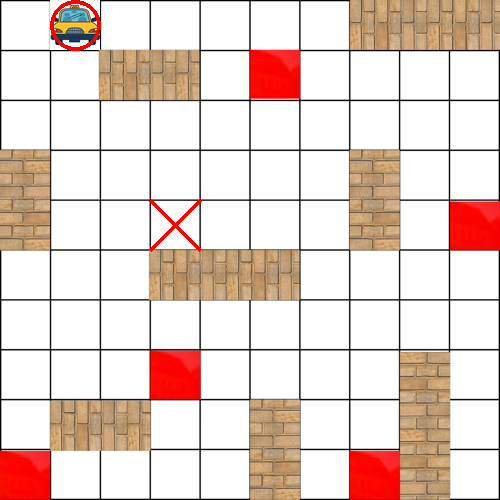

In [9]:
# Q-learning eğitimi
for episode in range(episodes):
    state = env.reset()
    done = False

    while not done:
        if episode < 10:
            env.render(0.2)

        if random.uniform(0, 1) < epsilon or state not in q_table:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])

        next_state, reward, done, _ = env.step(action)

        if state not in q_table:
            q_table[state] = np.zeros(env.action_space.n)
        if next_state not in q_table:
            q_table[next_state] = np.zeros(env.action_space.n)

        old_value = q_table[state][action]
        next_max = np.max(q_table[next_state])
        q_table[state][action] = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)

        state = next_state

In [10]:
# Q-tablosunu Google Drive'daki 'taksi' klasörüne kaydet
with open("/content/drive/MyDrive/taksi/q_table.pkl", "wb") as f:
    pickle.dump(q_table, f)

print("Q-table başarıyla Google Drive > taksi klasörüne kaydedildi.")

Q-table başarıyla Google Drive > taksi klasörüne kaydedildi.
